In [1]:
#Import required packages
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
#Load MNIST dataset
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


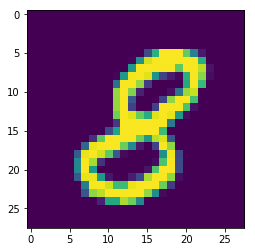

In [2]:
plt.imshow(mnist.train.images[5].reshape([28, 28]))
print(mnist.train.labels[5])

In [3]:
n_tr = mnist.train.images.shape[0]# number of training samples
n_ts = mnist.test.images.shape[0]#number of testing samples
n_pixel = mnist.train.images.shape[1]

## A Simple Feedforward Example 
Please refer to：https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

## Batch Nomalization For CNN Model

In [22]:
#Create weights
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.01)
  return tf.Variable(initial, name='weights')

#Create biases
def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial, name='biases')

In [23]:
#Convolutional function
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
#Max pool function
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [37]:
decay = 0.9
epsilon = 0.001
def conv_relu_pool(x, kernel_shape, bias_shape, is_training):
    # Create variable named "weights".
    weights = weight_variable(kernel_shape)
    # Create variable named "biases".
    biases = bias_variable(bias_shape)
    
    # Create two new parameters, gamma and beta (shift)
    #The bias for batch normalization
    gamma = tf.Variable(tf.ones(bias_shape))
    #
    beta = tf.Variable(tf.zeros(bias_shape))
    
    conv = conv2d(x, weights)    
    z = conv + biases
    
    moving_mean = tf.Variable(tf.zeros([z.get_shape()[-1]]), trainable=False)
    moving_var = tf.Variable(tf.ones([z.get_shape()[-1]]), trainable=False)
    axis = list(range(len(z.get_shape()) - 1))
    #If training
    if is_training:
        batch_mean, batch_var = tf.nn.moments(z, axis)
        train_mean = tf.assign(moving_mean,
                               moving_mean * decay + batch_mean * (1 - decay))
        train_var = tf.assign(moving_var,
                              moving_var * decay + batch_var * (1 - decay))
        with tf.control_dependencies([train_mean, train_var]):
            bn = tf.nn.batch_normalization(z,
                                           batch_mean, batch_var, beta, gamma, epsilon)    
    else:
        bn = tf.nn.batch_normalization(z, moving_mean, moving_var, beta, gamma, epsilon)
    #Activation    
    relu = tf.nn.relu(bn)
    pool = max_pool_2x2(relu)
    return pool

In [45]:
def cnnLayer(x, keep_prob, is_training):
    x_image = tf.reshape(x, [-1,28,28,1])
    #First Conv
    with tf.name_scope('hidden1'):
        kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
        h_pool1 = conv_relu_pool(x_image, kernel_shape, bias_shape, is_training)
        
    #Second Conv
    with tf.name_scope('hidden2'):
        kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
        h_pool2 = conv_relu_pool(h_pool1, kernel_shape, bias_shape, is_training)
    
    #Fully Connected Layer
    with tf.name_scope('fully_connected'):
        W_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #Softmax Layer
    with tf.variable_scope('softmax_layer'):
        W_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])
        logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return tf.nn.softmax(logits)

In [57]:
graph_cnn = tf.Graph()
with graph_cnn.as_default() as g:
    #Create input placeholders
    x = tf.placeholder(tf.float32, [None, 784])
    y_ = tf.placeholder(tf.float32, [None,10])
    #Define ropout probability placholder
    keep_prob = tf.placeholder("float")   

    y = cnnLayer(x, keep_prob, True)
    #Define cross-entropy as loss function
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    #Adam Optimizer
    train_step = tf.train.AdamOptimizer(0.0005).minimize(cross_entropy)
    #Define accuracy
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    saver = tf.train.Saver()


In [58]:
epochs = 1

batch_size = 64
num_steps = int(n_tr/batch_size)
#Create a session
with tf.Session(graph=graph_cnn) as sess:
    #Initialize variables
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
    for _ in range(epochs):
        for step in range(num_steps):
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 0.5}
            #Train
            _, loss = sess.run([train_step, cross_entropy], feed_dict=feed_dict)
            if step%500 == 0:
                feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
                loss = sess.run(cross_entropy, feed_dict=feed_dict)
                print('Loss:', loss)
     
    saved_model = saver.save(sess, 'temp/model.ckpt')

Loss: 124.399
Loss: 0.370755


In [59]:
with graph_cnn.as_default() as g:
    y = cnnLayer(x, keep_prob, False)

In [60]:
with tf.Session(graph=graph_cnn) as sess:
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.get_checkpoint_state('temp')
    saver.restore(sess, ckpt.model_checkpoint_path)
    count = 0    
    for _ in range(200):
        batch_data, batch_labels = mnist.train.next_batch(50)
        feed_dict = {x : batch_data, y_ : batch_labels, keep_prob: 1}
        cp = sess.run(correct_prediction, feed_dict=feed_dict)
        count += np.sum(cp)
    print("Testing Accuracy：", count/n_ts)

INFO:tensorflow:Restoring parameters from temp\model.ckpt
Testing Accuracy： 0.981


In [48]:
#Below code was referred to http://danijar.com/structuring-your-tensorflow-models/
import functools
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.

    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__#Get function name
    name = scope or function.__name__
    @property
    @functools.wraps(function)#Keep the original function
    def decorator(self):
        if not hasattr(self, attribute):#If the attribute not exist
            with tf.variable_scope(name, *args, **kwargs):#Add scope name
                setattr(self, attribute, function(self))
        return getattr(self, attribute)#otherwise return the attribute
    return decorator

In [49]:
#定义一个MNIST分类的基类
class MnistModel:
    '''Define a basic model for MNIST image classification, the model
    Provides graph structure of tensorflow'''
    
    def __init__(self, input_holder, target_holder, is_training, keep_prob):
        self.input_holder = input_holder
        self.target_holder = target_holder
        self.is_training = is_training
        self.num_pixel = 784
        self.num_class = 10
        self.keep_prob = keep_prob
        self.prediction
        self.optimize
        self.accuracy
        print('Initializing Mnist Model!') 
    
    @define_scope(initializer=tf.contrib.slim.xavier_initializer())
    def prediction(self):
        return None
    
    @define_scope
    def optimize(self):
        return None
    
    @define_scope
    def accuracy(self):
        return None
    

Reference:https://github.com/ry/tensorflow-resnet/blob/master/resnet.py
https://gist.github.com/tomokishii/0ce3bdac1588b5cca9fa5fbdf6e1c412
https://r2rt.com/implementing-batch-normalization-in-tensorflow.html

In [66]:
from tensorflow.python.training import moving_averages
from tensorflow.python.ops import control_flow_ops
class CnnMnistModel(MnistModel):
    #重构某些函数
    
    @define_scope(initializer=tf.contrib.slim.xavier_initializer())
    def prediction(self):
        #定义权重和偏置参数变量
        logits = self.cnnLayer
        return tf.nn.softmax(logits)

    @define_scope
    def optimize(self):
        cross_entropy = -tf.reduce_sum(self.target_holder*
                                       tf.log(self.prediction))
        optimizer = tf.train.AdamOptimizer(1e-4)
        return optimizer.minimize(cross_entropy)

    @define_scope
    def accuracy(self):
        correct_prediction = tf.equal(tf.argmax(self.target_holder,1), 
                                      tf.argmax(self.prediction,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy
    
    @define_scope
    def cnnLayer(self):
        x_image = tf.reshape(self.input_holder, [-1,28,28,1])
        #First Conv
        with tf.name_scope('hidden1'):
            kernel_shape, bias_shape = [5, 5, 1, 32], [32] 
            h_pool1 = self.conv_relu_bn_pool(x_image, kernel_shape, bias_shape)
            #Second Conv
        with tf.name_scope('hidden2'):
            kernel_shape, bias_shape = [5, 5, 32, 64], [64] 
            h_pool2 = self.conv_relu_bn_pool(h_pool1, kernel_shape, bias_shape)
    
        #Fully Connected Layer
        with tf.name_scope('fully_connected'):
            W_fc1 = self.weight_variable([7 * 7 * 64, 1024])
            b_fc1 = self.bias_variable([1024])
            h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
            h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        #Dropout, to prevent against overfitting      
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
        #Softmax Layer
        with tf.name_scope('softmax_layer'):
            W_fc2 = weight_variable([1024, 10])
            b_fc2 = bias_variable([10])
            logits = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
            
        return logits
    
    #卷积函数
    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    
    #池化函数
    def max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1], padding='SAME')
    
    #Create weights
    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial, name='weights')

    #Create biases
    def bias_variable(self, shape):
        initial = tf.constant(0.01, shape=shape)
        return tf.Variable(initial, name='biases')
    

    def _get_variable(self, name,
                  shape,
                  initializer,
                  weight_decay=0.0,
                  trainable=True):
        "A little wrapper around tf.get_variable to do weight decay and add to"
        "resnet collection"

            
        return tf.get_variable(name,
                           shape=shape,
                           initializer=initializer,
                           dtype=tf.float32,
                           trainable=trainable)

    def conv_relu_bn_pool(self, x, kernel_shape, bias_shape):
        # Create variable named "weights".
        weights = self.weight_variable(kernel_shape)
        # Create variable named "biases".
        biases = self.bias_variable(bias_shape)
        conv = self.conv2d(x, weights)
        bn = self.batch_normalization(conv)
        relu = tf.nn.relu(bn + biases)
        pool = self.max_pool_2x2(relu)
        return pool
    


    def batch_normalization(self, x):
        x_shape = x.get_shape()
        params_shape = x_shape[-1:]
        axis = list(range(len(x_shape) - 1))
        #The bias for batch normalization
        beta = self._get_variable('beta',
                             params_shape,
                             initializer=tf.zeros_initializer)
        #The scale of batch normalization
        gamma = self._get_variable('gamma',
                              params_shape,
                              initializer=tf.ones_initializer)
        #Record moving average for testing
        moving_mean = self._get_variable('moving_mean',
                                    params_shape,
                                    initializer=tf.zeros_initializer,
                                    trainable=False)
        #Record moving average for testing
        moving_variance = self._get_variable('moving_variance',
                                    params_shape,
                                    initializer=tf.ones_initializer,
                                    trainable=False)  
        # These ops will only be preformed when training.
        mean, variance = tf.nn.moments(x, axis)
        #Update moving averages
        update_moving_mean = moving_averages.assign_moving_average(moving_mean,
                                                               mean, 0.9997)
        update_moving_variance = moving_averages.assign_moving_average(moving_variance, 
                                                                       variance, 0.9997)
        tf.add_to_collection("UPDATE_OPS_COLLECTION", update_moving_mean)
        tf.add_to_collection("UPDATE_OPS_COLLECTION", update_moving_variance)        
        if self.is_training:
            mean, variance = mean, variance
        else:
            mean, variance = moving_mean, moving_variance 
        x = tf.nn.batch_normalization(x, mean, variance, beta, gamma, 0.001)
        return x

In [67]:
num_steps = 1001
batch_size = 64
num_pixel = 784
num_class = 10
#定义feed数据
#定义输入数据
input_holder = tf.placeholder(tf.float32, [None, num_pixel])
#输入数据对应标签
target_holder = tf.placeholder(tf.float32, [None,num_class])
cnn_model = CnnMnistModel(input_holder, target_holder, True, 0.5)

ValueError: Variable prediction/cnnLayer/beta already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
